<a href="https://colab.research.google.com/github/john-woolley/BERTNotebook/blob/main/BERT_Exploration_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Exploration Notebook
Code updated from original based on work by  Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [ ]:
import transformers
transformers.__version__

'4.13.0.dev0'

In [ ]:
import torch
import datasets
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForQuestionAnswering, AdamW
from transformers.data.processors.squad import SquadV2Processor, squad_convert_examples_to_features
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
torch.__version__

'1.10.0+cu102'

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
device = torch.device("cuda")

In [ ]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [ ]:
cached_features_file = 'cache_train'
question_column_name = 'question'
context_column_name = 'context'
answer_column_name = 'answers'
pad_on_right = False
pad_to_max_length = False

In [ ]:
cached_features_file = 'cache_train'
if not os.path.exists(cached_features_file):
  processor = SquadV2Processor()
  examples = processor.get_train_examples('', filename='train-v2.0.json')
  features, dataset = squad_convert_examples_to_features(examples=examples,
                                                tokenizer=tokenizer,
                                                max_seq_length=max_seq_length,
                                                doc_stride=doc_stride,
                                                max_query_length=max_query_length,
                                                is_training=True,
                                                return_dataset="pt",
                                                threads=32)
  torch.save(features, cached_features_file)
else:
  features, dataset = torch.load(cached_features_file)

In [ ]:
features[0]

In [ ]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, #all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [ ]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [ ]:
import glob
checkpoints = sorted(glob.glob('checkpoint*-[0-9]*'))

In [ ]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [ ]:
config = PretrainedConfig.from_json_file('base_config.json')

In [ ]:
print(type(config))

<class 'transformers.configuration_utils.PretrainedConfig'>


In [ ]:
# if len(checkpoints) > 0:
#   global_step = checkpoints[-1].split('-')[-1]
#   ckpt_name = '~/checkpoint-{}'.format(global_step)
#   print("Loading model from checkpoint %s" % ckpt_name)
#   model = BertForQuestionAnswering.from_pretrained(ckpt_name)
#   train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
#   train_loss_set = to_list(train_loss_set_ckpt)
#   tr_loss = train_loss_set[-1]
# else:
global_step = 0
train_loss_set = []
tr_loss = 0.0
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
class EnsembleBertQA(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        # model for QA
        self.bert_model_1 = BertForQuestionAnswering(config)
        # model for AQ
        self.bert_model_2 = BertForQuestionAnswering(config)
        # combine the 2 models into 1
        self.cls = torch.nn.Linear(2 * self.config.hidden_size, 2)

        # Initialize weights and apply final processing
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        start_positions=None,
        end_positions=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        start_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the start of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        end_positions (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for position (index) of the end of the labelled span for computing the token classification loss.
            Positions are clamped to the length of the sequence (:obj:`sequence_length`). Position outside of the
            sequence are not taken into account for computing the loss.
        """
        # return_dict = return_dict if return_dict is not None else self.config.use_return_dict


        outputs = []
        outputs.append(self.bert_model_1(input_ids,
                                        attention_mask=attention_mask_1,
                                        token_type_ids=token_type_ids_1,
                                        start_positions=start_positions_1,
                                        end_positions=end_positions_1))
        outputs.append(self.bert_model_2(input_ids,
                                        attention_mask=attention_mask,
                                        token_type_ids=token_type_ids,
                                        start_positions=start_positions,
                                        end_positions=end_positions))

        # just get the [CLS] embeddings
        last_hidden_states = torch.cat([output[1] for output in outputs], dim=1)
        logits = self.cls(last_hidden_states)
        sequence_output = outputs[0]

        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1).contiguous()
        end_logits = end_logits.squeeze(-1).contiguous()

        total_loss = None
        if start_positions is not None and end_positions is not None:
            # If we are on multi-GPU, split add a dimension
            if len(start_positions.size()) > 1:
                start_positions = start_positions.squeeze(-1)
            if len(end_positions.size()) > 1:
                end_positions = end_positions.squeeze(-1)
            # sometimes the start/end positions are outside our model inputs, we ignore these terms
            ignored_index = start_logits.size(1)
            start_positions = start_positions.clamp(0, ignored_index)
            end_positions = end_positions.clamp(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            total_loss = (start_loss + end_loss) / 2

        if not return_dict:
            output = (start_logits, end_logits) + outputs[2:]
            return ((total_loss,) + output) if total_loss is not None else output

        return QuestionAnsweringModelOutput(
            loss=total_loss,
            start_logits=start_logits,
            end_logits=end_logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

NameError: ignored

In [ ]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0142, -0.0615,  0.0016,  ...,  0.0312,  0.0050, -0.0142],
        [-0.0037,  0.0014,  0.0071,  ...,  0.0117, -0.0220, -0.0248]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [ ]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [ ]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

global_step = 0
for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = 'checkpoint-hidden-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 9016


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
output_dir = 'checkpoint-final-ensemble'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))

In [ ]:
train_loss_set_ckpt = torch.load('checkpoint-final-ensemble/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

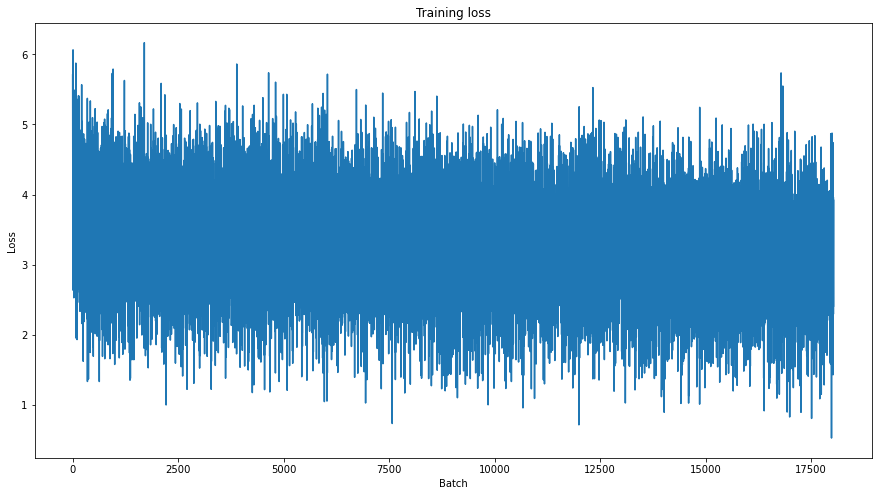

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [ ]:
input_file = 'dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = 'cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [ ]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = 'dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "predictions.json"
  output_nbest_file = "nbest_predictions.json"
  output_null_log_odds_file = "null_odds.json"
  output_dir = "predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer)

***** Running evaluation *****
  Num examples = 13600
  Batch size = 8


Evaluating: 100%|██████████| 1700/1700 [03:08<00:00,  9.03it/s]


{
  "exact": 49.97894382211741,
  "f1": 50.02029893312125,
  "total": 11873,
  "HasAns_exact": 0.2699055330634278,
  "HasAns_f1": 0.352734351037212,
  "HasAns_total": 5928,
  "NoAns_exact": 99.54583683767872,
  "NoAns_f1": 99.54583683767872,
  "NoAns_total": 5945,
  "best_exact": 50.08001347595385,
  "best_exact_thresh": -0.34941720962524414,
  "best_f1": 50.09389224363646,
  "best_f1_thresh": -0.34941720962524414
}


In [ ]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results_ensemble.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 49.97894382211741}, {'f1': 50.02029893312125}, {'total': 11873}, {'HasAns_exact': 0.2699055330634278}, {'HasAns_f1': 0.352734351037212}, {'HasAns_total': 5928}, {'NoAns_exact': 99.54583683767872}, {'NoAns_f1': 99.54583683767872}, {'NoAns_total': 5945}, {'best_exact': 50.08001347595385}, {'best_exact_thresh': -0.34941720962524414}, {'best_f1': 50.09389224363646}, {'best_f1_thresh': -0.34941720962524414}]


In [ ]:
model.config.to_json_file('base_config.json')